## Heteroscedastic uncertainty

### Example of learning the aleatoric heteroscedastic uncertainty by learning a simple linear regression

In [1]:
#!pip install keras==2.0.8
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense, concatenate, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop, Nadam
from keras.initializers import RandomNormal
from keras.layers import multiply, add
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


First we create some samples from 0 to 40 and add some noise. In this case we have two variables with the same noise distribution, x and z, that we'll use to show that gimas can be calculated using two variables as inputs.

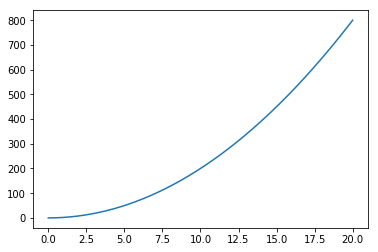

In [2]:
x = np.linspace(0, 20, 10000)#, dtype="int32")  # 100000 values between 0 and 100
deltax = np.random.normal(0, 2, x.size)
z = np.linspace(0, 20, 10000)
deltaz = np.random.normal(0, 2, z.size)
y = 2 * x * z
x_prima = x + deltax
z_prima = z + deltaz
plt.plot(x,y)
plt.show()

Epoch 1/200
10000/10000 [==============================] - 0s - loss: 378676.5182 - mean_squared_error: 378676.5182   
Epoch 2/200
10000/10000 [==============================] - 0s - loss: 365278.5442 - mean_squared_error: 365278.5442   
Epoch 3/200
10000/10000 [==============================] - 0s - loss: 354244.5350 - mean_squared_error: 354244.5350   
Epoch 4/200
10000/10000 [==============================] - 0s - loss: 343766.7284 - mean_squared_error: 343766.7284   
Epoch 5/200
10000/10000 [==============================] - 0s - loss: 333658.4843 - mean_squared_error: 333658.4843   
Epoch 6/200
10000/10000 [==============================] - 0s - loss: 323849.0188 - mean_squared_error: 323849.0188   
Epoch 7/200
10000/10000 [==============================] - 0s - loss: 314302.8324 - mean_squared_error: 314302.8324   
Epoch 8/200
10000/10000 [==============================] - 0s - loss: 304997.7282 - mean_squared_error: 304997.7282   
Epoch 9/200
10000/10000 [=======================

10000/10000 [==============================] - 0s - loss: 21330.6642 - mean_squared_error: 21330.6642   
Epoch 70/200
10000/10000 [==============================] - 0s - loss: 20004.1472 - mean_squared_error: 20004.1472   
Epoch 71/200
10000/10000 [==============================] - 0s - loss: 18749.9242 - mean_squared_error: 18749.9242   
Epoch 72/200
10000/10000 [==============================] - 0s - loss: 17566.1091 - mean_squared_error: 17566.1091   
Epoch 73/200
10000/10000 [==============================] - 0s - loss: 16450.7429 - mean_squared_error: 16450.7429   
Epoch 74/200
10000/10000 [==============================] - 0s - loss: 15401.9162 - mean_squared_error: 15401.9162   
Epoch 75/200
10000/10000 [==============================] - 0s - loss: 14417.6273 - mean_squared_error: 14417.6273   
Epoch 76/200
10000/10000 [==============================] - 0s - loss: 13495.8554 - mean_squared_error: 13495.8554   
Epoch 77/200
10000/10000 [==============================] - 0s - loss

10000/10000 [==============================] - 0s - loss: 4249.7797 - mean_squared_error: 4249.7797     
Epoch 139/200
10000/10000 [==============================] - 0s - loss: 4249.8698 - mean_squared_error: 4249.8698     
Epoch 140/200
10000/10000 [==============================] - 0s - loss: 4249.9617 - mean_squared_error: 4249.9617     
Epoch 141/200
10000/10000 [==============================] - 0s - loss: 4250.0546 - mean_squared_error: 4250.0546     
Epoch 142/200
10000/10000 [==============================] - 0s - loss: 4250.1501 - mean_squared_error: 4250.1501     
Epoch 143/200
10000/10000 [==============================] - 0s - loss: 4250.2470 - mean_squared_error: 4250.2470     
Epoch 144/200
10000/10000 [==============================] - 0s - loss: 4250.3457 - mean_squared_error: 4250.3457     
Epoch 145/200
10000/10000 [==============================] - 0s - loss: 4250.4457 - mean_squared_error: 4250.4457     
Epoch 146/200
10000/10000 [==============================] - 0

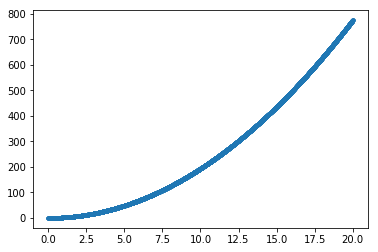

In [3]:
raw_input1 = Input(shape=(1,))
raw_input2 = Input(shape=(1,))
product = multiply([raw_input1,raw_input2])
raw_preds = Dense(1, activation='linear', name="preds", use_bias=False)(product)

rawmodel = Model(inputs=[raw_input1,raw_input2],outputs=raw_preds)
rawmodel.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
rawmodel.fit([x_prima, z_prima], y, batch_size=128, epochs=200, shuffle=False)
raw_result = rawmodel.predict([x, z])
plt.plot(x, raw_result[:,0],'.')
plt.show()

In [4]:
rawmodel.layers[3].get_weights()

[array([[ 1.93669915]], dtype=float32)]

These are the function used to include the calculation of the sigmas in the loss.
Note that we use the trick of concatenating the sigma to the ouput, so the prediction is at index 0 and the sigma is at index 1 of the resulting output. Note that differently from the 1 input version, in this case the sigma is not squared. This is because the sigma here applied is the combination of the sigmas of the 2 inputs, each of them squared in the model

In [50]:
def aleatoric_loss(y_true, y_pred):
    sigma1 = y_pred[:, 1]
    sigma2 = y_pred[:, 2]
    sigmas = K.pow((K.pow(K.square(sigma1), -1) + K.pow(K.square(sigma2), -1)),-1)
    epsilon = 1e-6
    y_pred_prima = y_pred[:, 0]
    output_value = ((K.square(y_pred_prima - y_true[:, 0])) / (sigmas+ epsilon)) + K.log(sigmas + epsilon)
    return K.mean(output_value, axis=-1)

def aleatoric_rms(y_true, y_pred):
    y_pred_prima = y_pred[:, 0]
    return K.mean(K.square(y_pred_prima - y_true[:, 0]), axis=-1)

First we try a model without calculating the sigma and plot some results.

Then we try a model where the sigmas are computed. In this case we have two sigmas, on for each input, that share the same network. Sigmas are squared and combined, by adding them, as a resulting sigma that is train in the loss together with the mean squared error of the labels and the predictions.

In [51]:
input1 = Input(shape=(1,))
input2 = Input(shape=(1,))
sigma_hidden1 = Dense(64, activation='relu', name="sigma", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))
sigma_hidden2 = Dense(16, activation='relu', name="sigma2", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))
sigma_hidden3 = Dense(4, activation='relu', name="sigma3", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))
sigma_output = Dense(1, activation='linear', name="sigma4", kernel_initializer=RandomNormal(mean=1.0, stddev=0.05, seed=None))
product = multiply([input1,input2])
preds = Dense(1, activation='linear', name="preds", use_bias=False, weights=rawmodel.layers[3].get_weights())(product)
sigma1_hidden1 = sigma_hidden1(input1)
sigma1_hidden2 = sigma_hidden2(sigma1_hidden1)
sigma1_hidden3 = sigma_hidden3(sigma1_hidden2)
sigma1 = sigma_output(sigma1_hidden3)
sigma2_hidden1 = sigma_hidden1(input2)
sigma2_hidden2 = sigma_hidden2(sigma2_hidden1)
sigma2_hidden3 = sigma_hidden3(sigma2_hidden2)
sigma2 = sigma_output(sigma2_hidden3)
aleatoric_output = concatenate([preds, sigma1, sigma2])
model = Model(inputs=[input1,input2],outputs=aleatoric_output)
model.compile(optimizer=Adam(lr=0.00005), loss=aleatoric_loss, metrics=[aleatoric_rms])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_27 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
input_28 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
sigma (Dense)                    (None, 64)            128         input_27[0][0]                   
                                                                   input_28[0][0]                   
____________________________________________________________________________________________________
sigma2 (Dense)                   (None, 16)            1040        sigma[0][0]             

In [52]:
model.fit([x_prima, z_prima], np.expand_dims(y, axis=1).repeat(2, axis=1), batch_size=128, epochs=1000, shuffle=False)

Epoch 1/1000
10000/10000 [==============================] - 0s - loss: 870438.3475 - aleatoric_rms: 4247.2390      
Epoch 2/1000
10000/10000 [==============================] - 0s - loss: 306345.0916 - aleatoric_rms: 4247.8410     
Epoch 3/1000
10000/10000 [==============================] - 0s - loss: 220531.2597 - aleatoric_rms: 4248.3723     
Epoch 4/1000
10000/10000 [==============================] - 0s - loss: 170653.8521 - aleatoric_rms: 4248.8434     
Epoch 5/1000
10000/10000 [==============================] - 0s - loss: 136798.2636 - aleatoric_rms: 4249.2874     
Epoch 6/1000
10000/10000 [==============================] - 0s - loss: 112895.2979 - aleatoric_rms: 4249.7252     
Epoch 7/1000
10000/10000 [==============================] - 0s - loss: 96019.1586 - aleatoric_rms: 4250.1588      
Epoch 8/1000
10000/10000 [==============================] - 0s - loss: 82539.7511 - aleatoric_rms: 4250.5893     
Epoch 9/1000
10000/10000 [==============================] - 0s - loss: 70806.740

10000/10000 [==============================] - 0s - loss: 1643.4512 - aleatoric_rms: 4265.6290     
Epoch 73/1000
10000/10000 [==============================] - 0s - loss: 1581.5624 - aleatoric_rms: 4265.8416     
Epoch 74/1000
10000/10000 [==============================] - 0s - loss: 1522.4730 - aleatoric_rms: 4266.0555     
Epoch 75/1000
10000/10000 [==============================] - 0s - loss: 1466.0256 - aleatoric_rms: 4266.2703     
Epoch 76/1000
10000/10000 [==============================] - 0s - loss: 1412.0715 - aleatoric_rms: 4266.4861     
Epoch 77/1000
10000/10000 [==============================] - 0s - loss: 1360.4748 - aleatoric_rms: 4266.7027     
Epoch 78/1000
10000/10000 [==============================] - 0s - loss: 1311.1090 - aleatoric_rms: 4266.9202     A: 0s - loss: 2149.0823 - aleatoric_rms: 646.0
Epoch 79/1000
10000/10000 [==============================] - 0s - loss: 1263.8539 - aleatoric_rms: 4267.1392     
Epoch 80/1000
10000/10000 [=============================

10000/10000 [==============================] - 0s - loss: 162.5262 - aleatoric_rms: 4284.0829     
Epoch 144/1000
10000/10000 [==============================] - 0s - loss: 157.8529 - aleatoric_rms: 4284.3950     
Epoch 145/1000
10000/10000 [==============================] - 0s - loss: 153.3243 - aleatoric_rms: 4284.7079     
Epoch 146/1000
10000/10000 [==============================] - 0s - loss: 148.9358 - aleatoric_rms: 4285.0222     
Epoch 147/1000
10000/10000 [==============================] - 0s - loss: 144.6824 - aleatoric_rms: 4285.3393     
Epoch 148/1000
10000/10000 [==============================] - 0s - loss: 140.5600 - aleatoric_rms: 4285.6564     
Epoch 149/1000
10000/10000 [==============================] - 0s - loss: 136.5640 - aleatoric_rms: 4285.9742     
Epoch 150/1000
10000/10000 [==============================] - 0s - loss: 132.6906 - aleatoric_rms: 4286.2943     
Epoch 151/1000
10000/10000 [==============================] - 0s - loss: 128.9355 - aleatoric_rms: 4286

10000/10000 [==============================] - 0s - loss: 25.0107 - aleatoric_rms: 4307.1066     
Epoch 216/1000
10000/10000 [==============================] - 0s - loss: 24.4933 - aleatoric_rms: 4307.4008     
Epoch 217/1000
10000/10000 [==============================] - 0s - loss: 23.9914 - aleatoric_rms: 4307.6956     
Epoch 218/1000
10000/10000 [==============================] - 0s - loss: 23.5044 - aleatoric_rms: 4307.9891     
Epoch 219/1000
10000/10000 [==============================] - 0s - loss: 23.0321 - aleatoric_rms: 4308.2789     
Epoch 220/1000
10000/10000 [==============================] - 0s - loss: 22.5740 - aleatoric_rms: 4308.5671     
Epoch 221/1000
10000/10000 [==============================] - 0s - loss: 22.1296 - aleatoric_rms: 4308.8543     
Epoch 222/1000
10000/10000 [==============================] - 0s - loss: 21.6986 - aleatoric_rms: 4309.1381     
Epoch 223/1000
10000/10000 [==============================] - 0s - loss: 21.2806 - aleatoric_rms: 4309.4216    

10000/10000 [==============================] - 0s - loss: 9.9849 - aleatoric_rms: 4323.4712     
Epoch 288/1000
10000/10000 [==============================] - 0s - loss: 9.9369 - aleatoric_rms: 4323.6445     
Epoch 289/1000
10000/10000 [==============================] - 0s - loss: 9.8908 - aleatoric_rms: 4323.8163     
Epoch 290/1000
10000/10000 [==============================] - 0s - loss: 9.8464 - aleatoric_rms: 4323.9879     
Epoch 291/1000
10000/10000 [==============================] - 0s - loss: 9.8038 - aleatoric_rms: 4324.1586     
Epoch 292/1000
10000/10000 [==============================] - 0s - loss: 9.7628 - aleatoric_rms: 4324.3290     
Epoch 293/1000
10000/10000 [==============================] - 0s - loss: 9.7234 - aleatoric_rms: 4324.4985      ETA: 0s - loss: 9.4719 - aleatoric_rms: 2226.19
Epoch 294/1000
10000/10000 [==============================] - 0s - loss: 9.6856 - aleatoric_rms: 4324.6701     
Epoch 295/1000
10000/10000 [==============================] - 0s - loss

10000/10000 [==============================] - 0s - loss: 8.8719 - aleatoric_rms: 4340.0958     
Epoch 360/1000
10000/10000 [==============================] - 0s - loss: 8.8688 - aleatoric_rms: 4340.3675     
Epoch 361/1000
10000/10000 [==============================] - 0s - loss: 8.8657 - aleatoric_rms: 4340.6348     
Epoch 362/1000
10000/10000 [==============================] - 0s - loss: 8.8628 - aleatoric_rms: 4340.8962     
Epoch 363/1000
10000/10000 [==============================] - 0s - loss: 8.8599 - aleatoric_rms: 4341.1521     
Epoch 364/1000
10000/10000 [==============================] - 0s - loss: 8.8570 - aleatoric_rms: 4341.4017     
Epoch 365/1000
10000/10000 [==============================] - 0s - loss: 8.8543 - aleatoric_rms: 4341.6444     
Epoch 366/1000
10000/10000 [==============================] - 0s - loss: 8.8516 - aleatoric_rms: 4341.8797     
Epoch 367/1000
10000/10000 [==============================] - 0s - loss: 8.8490 - aleatoric_rms: 4342.1074     
Epoch 3

10000/10000 [==============================] - 0s - loss: 8.7798 - aleatoric_rms: 4343.2298     
Epoch 433/1000
10000/10000 [==============================] - 0s - loss: 8.7796 - aleatoric_rms: 4343.1472     
Epoch 434/1000
10000/10000 [==============================] - 0s - loss: 8.7794 - aleatoric_rms: 4343.0627     
Epoch 435/1000
10000/10000 [==============================] - 0s - loss: 8.7792 - aleatoric_rms: 4342.9796     
Epoch 436/1000
10000/10000 [==============================] - 0s - loss: 8.7790 - aleatoric_rms: 4342.8971     
Epoch 437/1000
10000/10000 [==============================] - 0s - loss: 8.7788 - aleatoric_rms: 4342.8146     
Epoch 438/1000
10000/10000 [==============================] - 0s - loss: 8.7787 - aleatoric_rms: 4342.7317     
Epoch 439/1000
10000/10000 [==============================] - 0s - loss: 8.7785 - aleatoric_rms: 4342.6514     
Epoch 440/1000
10000/10000 [==============================] - 0s - loss: 8.7784 - aleatoric_rms: 4342.5692     
Epoch 4

10000/10000 [==============================] - 0s - loss: 8.7757 - aleatoric_rms: 4338.9186     
Epoch 506/1000
10000/10000 [==============================] - 0s - loss: 8.7757 - aleatoric_rms: 4338.8873     
Epoch 507/1000
10000/10000 [==============================] - 0s - loss: 8.7757 - aleatoric_rms: 4338.8550     
Epoch 508/1000
10000/10000 [==============================] - 0s - loss: 8.7757 - aleatoric_rms: 4338.8234     
Epoch 509/1000
10000/10000 [==============================] - 0s - loss: 8.7757 - aleatoric_rms: 4338.7932     
Epoch 510/1000
10000/10000 [==============================] - 0s - loss: 8.7757 - aleatoric_rms: 4338.7632     
Epoch 511/1000
10000/10000 [==============================] - 0s - loss: 8.7757 - aleatoric_rms: 4338.7343     
Epoch 512/1000
10000/10000 [==============================] - 0s - loss: 8.7757 - aleatoric_rms: 4338.7061     
Epoch 513/1000
10000/10000 [==============================] - 0s - loss: 8.7757 - aleatoric_rms: 4338.6773     
Epoch 5

10000/10000 [==============================] - 0s - loss: 8.7755 - aleatoric_rms: 4337.4879     
Epoch 579/1000
10000/10000 [==============================] - 0s - loss: 8.7755 - aleatoric_rms: 4337.4768     
Epoch 580/1000
10000/10000 [==============================] - 0s - loss: 8.7755 - aleatoric_rms: 4337.4656     
Epoch 581/1000
10000/10000 [==============================] - 0s - loss: 8.7755 - aleatoric_rms: 4337.4544     
Epoch 582/1000
10000/10000 [==============================] - 0s - loss: 8.7755 - aleatoric_rms: 4337.4432     
Epoch 583/1000
10000/10000 [==============================] - 0s - loss: 8.7755 - aleatoric_rms: 4337.4318     
Epoch 584/1000
10000/10000 [==============================] - 0s - loss: 8.7755 - aleatoric_rms: 4337.4202     
Epoch 585/1000
10000/10000 [==============================] - 0s - loss: 8.7755 - aleatoric_rms: 4337.4087     
Epoch 586/1000
10000/10000 [==============================] - 0s - loss: 8.7755 - aleatoric_rms: 4337.3975     
Epoch 5

10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.8763     
Epoch 651/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.8705     
Epoch 652/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.8647     
Epoch 653/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.8590     
Epoch 654/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.8535     
Epoch 655/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.8483     
Epoch 656/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.8429     
Epoch 657/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.8375     
Epoch 658/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.8321     
Epoch 6

10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.5335     
Epoch 724/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.5306     
Epoch 725/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.5275     
Epoch 726/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.5246     
Epoch 727/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.5217     
Epoch 728/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.5188     
Epoch 729/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.5160     
Epoch 730/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.5132     
Epoch 731/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.5100     
Epoch 7

10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.2768     
Epoch 796/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.2735     
Epoch 797/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.2706     
Epoch 798/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.2677     
Epoch 799/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.2649     
Epoch 800/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.2620     
Epoch 801/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.2591     
Epoch 802/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.2567     
Epoch 803/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4336.2542     
Epoch 8

10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4336.0979     
Epoch 869/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4336.0962     
Epoch 870/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4336.0946     
Epoch 871/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4336.0930      ETA: 0s - loss: 8.1925 - aleatoric_rms: 2233.78
Epoch 872/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4336.0913     
Epoch 873/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4336.0896     
Epoch 874/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4336.0877     
Epoch 875/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4336.0857     
Epoch 876/1000
10000/10000 [==============================] - 0s - loss

10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4335.9647     
Epoch 941/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4335.9633     
Epoch 942/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4335.9617     
Epoch 943/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4335.9600     
Epoch 944/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4335.9583     
Epoch 945/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4335.9567     
Epoch 946/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4335.9550     
Epoch 947/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4335.9534     
Epoch 948/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4335.9522     
Epoch 9

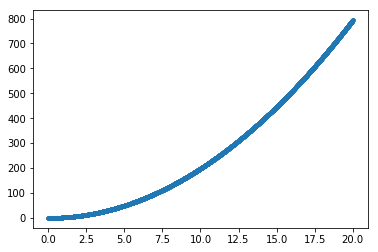

In [53]:
result = model.predict([x,z])
plt.plot(x, result[:,0],'.')
plt.show()

Here we plot the two sigmas. As we can see, the sigma for the first variable though for the second one the predicted sigma is quite wrong.

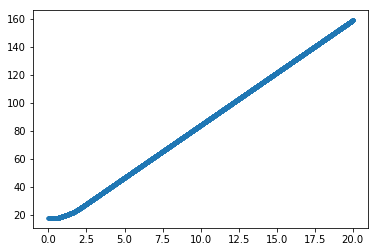

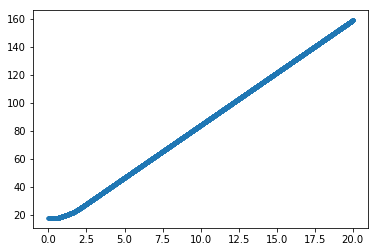

In [54]:
model_sigmas_x = Model(inputs=[input1], outputs=sigma1)
sigmas_x = model_sigmas_x.predict(x)
sigmas_x
plt.plot(x, np.abs(sigmas_x),'.')
plt.show()
model_sigmas_z = Model(inputs=[input2], outputs=sigma2)
sigmas_z = model_sigmas_z.predict(z)
sigmas_z
plt.plot(z, np.abs(sigmas_z),'.')
plt.show()

In [57]:
model.layers[6].get_weights()

[array([[ 1.98282671]], dtype=float32)]